<Body>   
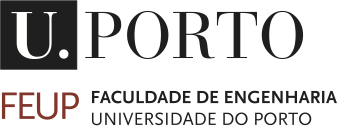   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Data preprocessing

In [53]:
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [54]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


In [55]:
class FraudDataset(Dataset):
 
  def __init__(self, dataframe, fraud = True):
    scaler = StandardScaler()
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [56]:
train_dataloader = DataLoader(creditData, batch_size=32, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=32, drop_last=True)

## Conditional Generative Adversarial Network

### Architecture

In [57]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64), #here
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(16, nr_features),
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [58]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        # nn.Linear(nr_features, 32),
        # nn.ReLU(inplace = True),
        # nn.Dropout(0.2),
        
        # nn.Linear(32, 16),
        # nn.ReLU(inplace = True),
        # nn.Dropout(0.2),
        
        # nn.Linear(16, 1),
        
        # )
        #nn.Linear(nr_features, 512), #here
        # nn.ReLU(),
        # nn.Linear(1024, 512),
        # nn.ReLU(),
        # nn.Dropout(0.2),
        
        nn.Linear(nr_features, 256), 
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(16, 1),
            
        )
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

####  Loss Function + Device + Reset Gradients Funct.

In [59]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 16
        self.n_critic = 1
        self.clip_value = 0.0001
        self.cur_batch_size = 64
        self.latent_dim = 128
        self.criterion = nn.BCELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(self.device)
        self.D = Discriminator(nr_features=self.dataset.features).to(self.device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.lr)

        



    def train_generator(self,real_data):
        # Clear generator gradients
        self.g_optimizer.zero_grad()

        fake_targets = torch.ones(real_data.size(0)).to(self.device)
        fake_targets = fake_targets - 0.1

        # Random noise from a uniform distribution
        latent_space_samples = torch.randn(real_data.size(0), self.latent_dim).to(self.device)
        generated_data = self.G(latent_space_samples)  # Fake data generated by the generator
        fake_preds = self.D(generated_data).reshape(-1)

        g_loss = self.criterion(fake_preds, fake_targets)
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss, generated_data

    def train_discriminator(self, real_data, real_labels):
    # Reset gradients
        
        self.d_optimizer.zero_grad()
        real_labels = torch.ones(real_data.size(0)).to(self.device) * 0.9
        
        real_preds = self.D(real_data).reshape(-1)
        d_loss_real = self.criterion(real_preds, real_labels)
        
        fake_labels = torch.zeros(self.cur_batch_size).to(self.device) * 0.1

        # random noise from uniform distribution
        latent_space_samples = torch.randn(self.cur_batch_size, self.latent_dim).to(self.device)

   
        generated_data = self.G(latent_space_samples).detach()  # fake data generated by generator
        fake_preds = self.D(generated_data).reshape(-1)
        d_loss_fake = self.criterion(fake_preds, fake_labels)
        #d_loss_fake = self.criterion(fake_preds, fake_labels)
        
        loss = d_loss_real + d_loss_fake

        # Compute gradients
        loss.backward()
        # Adjust the parameters using backprop
        self.d_optimizer.step()
        
            
        return loss

    def train(self,real_data, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(epochs):  
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                # Train discriminator
                d_error = self.train_discriminator(real_data, real_labels)
                #Clip weights of discriminator
                # for p in self.D.parameters():
                #     p.data.clamp_(-self.clip_value, self.clip_value)
                #Clip weights of generator
                # for p in self.G.parameters():
                #     p.data.clamp_(-self.clip_value, self.clip_value)


                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error, _ = self.train_generator(real_data)        
                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch, epoch, i+1, len(self.dataloader), d_error.item(), g_error.item()))
            
        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(self.device)
            gen = self.G(z)
            return gen.cpu().numpy()

In [60]:
gan = GAN(df_train)

In [61]:
losses_gen, losses_dis = gan.train(df_train, epochs=400)

Epoch [0/0], Step [25/25], d_loss: 8.1726, g_loss: 0.7065 

Epoch [1/1], Step [25/25], d_loss: 34.3630, g_loss: 0.7015 

Epoch [2/2], Step [25/25], d_loss: 19.4936, g_loss: 0.7120 

Epoch [3/3], Step [25/25], d_loss: 9.7148, g_loss: 0.7071 

Epoch [4/4], Step [25/25], d_loss: 8.8385, g_loss: 0.7161 

Epoch [5/5], Step [25/25], d_loss: 8.6743, g_loss: 0.7179 

Epoch [6/6], Step [25/25], d_loss: 10.6603, g_loss: 0.7288 

Epoch [7/7], Step [25/25], d_loss: 9.6932, g_loss: 0.7217 

Epoch [8/8], Step [25/25], d_loss: 20.2136, g_loss: 0.7304 

Epoch [9/9], Step [25/25], d_loss: 11.4319, g_loss: 0.7353 

Epoch [10/10], Step [25/25], d_loss: 11.1028, g_loss: 0.7448 

Epoch [11/11], Step [25/25], d_loss: 9.6659, g_loss: 0.7507 

Epoch [12/12], Step [25/25], d_loss: 9.7335, g_loss: 0.7551 

Epoch [13/13], Step [25/25], d_loss: 8.7685, g_loss: 0.7468 

Epoch [14/14], Step [25/25], d_loss: 9.7187, g_loss: 0.7652 

Epoch [15/15], Step [25/25], d_loss: 8.8391, g_loss: 0.7653 

Epoch [16/16], Step [2

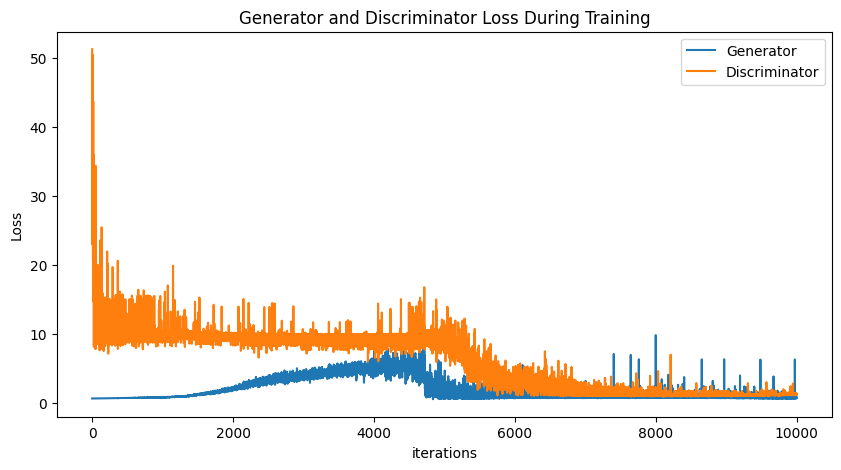

In [62]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.detach().numpy() for i in losses_gen]
    losses_dis = [i.detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

In [63]:
#define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
gan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, gan_df], ignore_index=True)

In [64]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
223361,143352.0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
165061,117173.0,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
238186,149565.0,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
150562,93670.0,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
138452,82655.0,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0


In [65]:
df_concat['Class'].value_counts()

Class
1.0    227845
0.0    227451
Name: count, dtype: int64

### Model evaluation

In [82]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced


def common_metrics(y_true, y_pred, y_prob):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
    RocCurveDisplay.from_predictions(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    #
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_true, y_prob, ax=ax)
    # P / (P + N)
    ap_frauds = (len(y_true[y_true == 1]) / len(y_true))
    plt.axhline(y=ap_frauds, color='r', linestyle='-') 
    plt.show()
    #
    print(classification_report_imbalanced(y_true, y_pred))
    print("AUPRC:", auc(recall, precision))
    print("AP:", average_precision_score(y_true, y_prob))

In [83]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [87]:

class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
        y_true = torch.Tensor(test_df['Class'].values).to(device)
        #preds = self.predict(input)
        preds = np.array([])
        dataloader_test = DataLoader(TensorDataset(input, y_true), batch_size=64, shuffle=False)
        
        for (inp, _) in dataloader_test:
            pred = self.predict(inp)
            preds = np.concatenate((preds, pred), axis=None)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        # ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        # print(classification_report(test_df['Class'].values, labels))
        # #calculate precision-recall curve
        # precision, recall, _ = precision_recall_curve(test_df['Class'].values, preds)
        # #print pr-auc
        # print('pr-auc: ', auc(recall, precision))
        common_metrics(y_true.cpu().numpy(), labels, preds)

[Epoch 0/1] loss: 3.130111


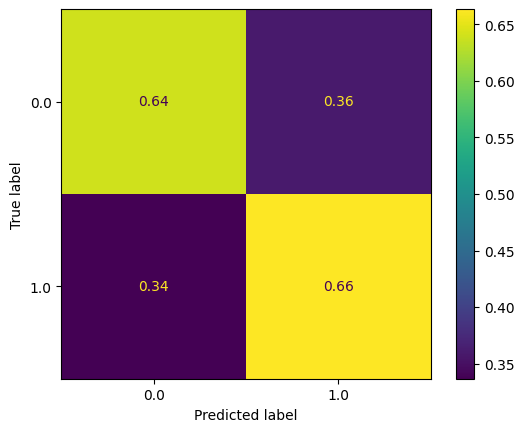

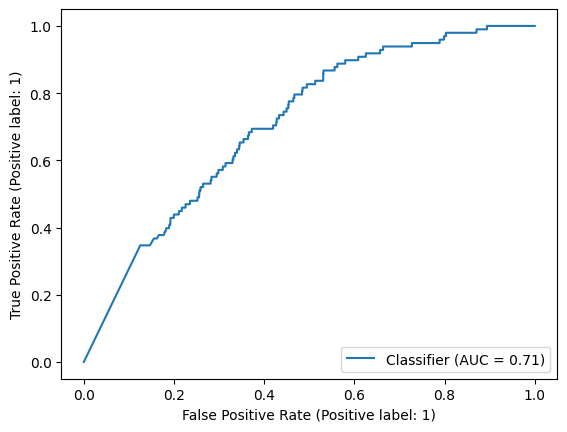

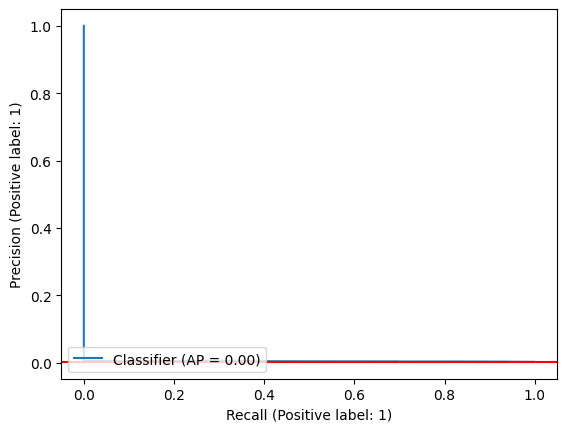

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.64      0.66      0.78      0.65      0.42     56864
        1.0       0.00      0.66      0.64      0.01      0.65      0.43        98

avg / total       1.00      0.64      0.66      0.78      0.65      0.42     56962

AUPRC: 0.17628618578991492
AP: 0.003656841076691013


In [88]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=100)
fw_model.evaluate(df_test, confidence=0.90)

### LSTM-Based Detection

In [78]:
#split df_concat into train and test
ltsm_train, ltsm_test = train_test_split(df_concat, test_size=0.2, random_state=42)

In [70]:
def create_time_dataset(in_df, seq_size=10):
    X, y = [], []
    for i in range(len(in_df) - seq_size):
        slice = in_df[i:i+seq_size]
        X.append(slice.drop(['Class', 'Time'], axis=1).values)
        y.append(slice['Class'].values[-1])
    return torch.Tensor(X).to(device), torch.Tensor(y).to(device)

In [71]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size = 256
        self.lstm = nn.LSTM(input_size,
                            hidden_size=self.hidden_size,
                            num_layers=5,
                            bidirectional=True,
                            batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x, hx = self.lstm(x)
        out = torch.cat((hx[0][-2, :, :], hx[0][-1, :, :]), dim=1)
        return torch.flatten(self.linear(out))

In [74]:
class LSTMFraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 128
        X_train, y_train = create_time_dataset(train_df)
        self.dataset = TensorDataset(X_train, y_train)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = LSTMModel(input_size=X_train.shape[2]).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input, y_true = create_time_dataset(test_df)
        dataloader = DataLoader(TensorDataset(input, y_true), self.batch_size, shuffle=False)
        preds = np.array([])
        for (inp, _) in dataloader:
            pred = self.predict(inp)
            preds = np.concatenate((preds, pred), axis=None)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(y_true.cpu().numpy(), labels, preds)

In [79]:
lstm = LSTMFraudModel(ltsm_train)

In [80]:
lstm.train()

KeyboardInterrupt: 